In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#
#
# An example of the type of datasets I typically work with. 
# Volumentric data from hydrodynamics simulations. "Volumetric"
# refers generally to any dataset that contains values of 
# physical quantities at various points in space. These are represented
# often 3D pixels (sometimes referred to as 'voxels'), 
# where each pixel (or 'grid point') is described by position
# coordinates and its physical quantities. In astrophysical hydrodynamics
# simulations, physical quantities are often things like density, temperature,
# pressure, velocity, and the composition of the gas (the abundance
# of specific elements or molecules).
# 
#
#
# Often in astronomy these datasets contain both 3D pixels representing
# properties of gas, and also 'particles' representing the positions of 
# things that interact only through gravity, like dark matter or 
# stars.
#
# These sets can vary in size, from anywhere from 10^6 to 10^10 
# elements, with anywhere from ~12 - 60 quantities associated with each element
# meaning individual 'snapshots' of the state of any given simulation at a 
# instant in time can range from a few hundred MB in size to a few TB. 
# Typically the ones I work with are on order of a 1 to 100 GB. But often
# there are ~100 - 1000 outputs per full simulation run.
# 

In [4]:
#
# To visualize this, here is a visualization of large simulation showing the
# density of gas around a 
#
import yt          # open-source package for analysis of general volumetric data
                   # written originally as an astronomy-specific toolkit, but since
                   # expanded. 

@yt.particle_filter(requires=["particle_type"], filtered_type='all')
def stars(pfilter, data):
    filter = data[(pfilter.filtered_type, "particle_type")] == 11
    return filter        
        
ds     = yt.load('./input/DD0116/DD0116')
ds.add_particle_filter('stars')

yt : [INFO     ] 2020-08-03 14:15:56,061 Parameters: current_time              = 33.708649672709
yt : [INFO     ] 2020-08-03 14:15:56,061 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2020-08-03 14:15:56,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-08-03 14:15:56,062 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-08-03 14:15:56,063 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-08-03 14:15:56,063 Parameters: current_redshift          = 7.4511468536779
yt : [INFO     ] 2020-08-03 14:15:56,064 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2020-08-03 14:15:56,064 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2020-08-03 14:15:56,065 Parameters: omega_radiation           = 0
yt : [INFO     ] 2020-08-03 14:15:56,065 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 1762/1762 [00:00<00:00, 13328.10it/s]
yt : [INFO     ] 2020-08-03 1

True

yt : [INFO     ] 2020-08-03 14:16:02,602 Projection completed
yt : [INFO     ] 2020-08-03 14:16:02,602 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-08-03 14:16:02,603 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-08-03 14:16:02,603 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-08-03 14:16:02,604 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-08-03 14:16:02,604 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



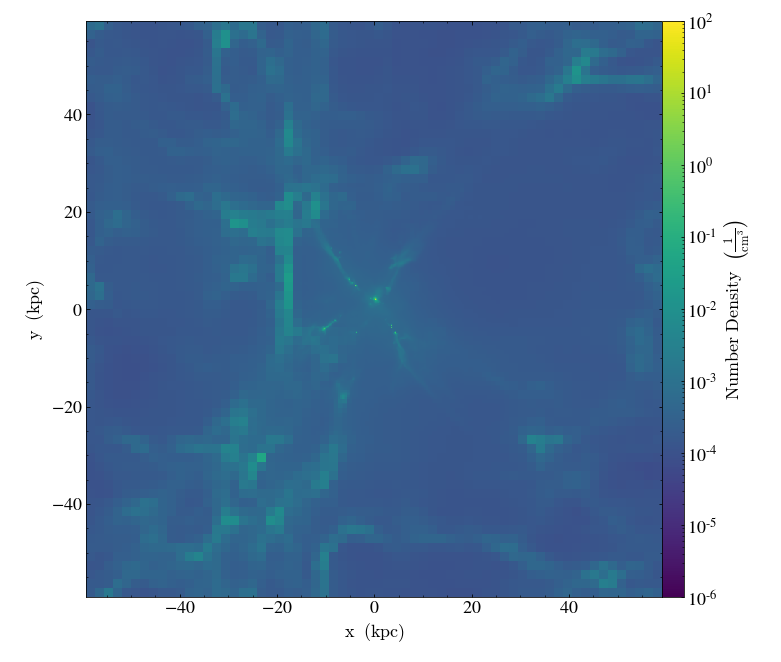


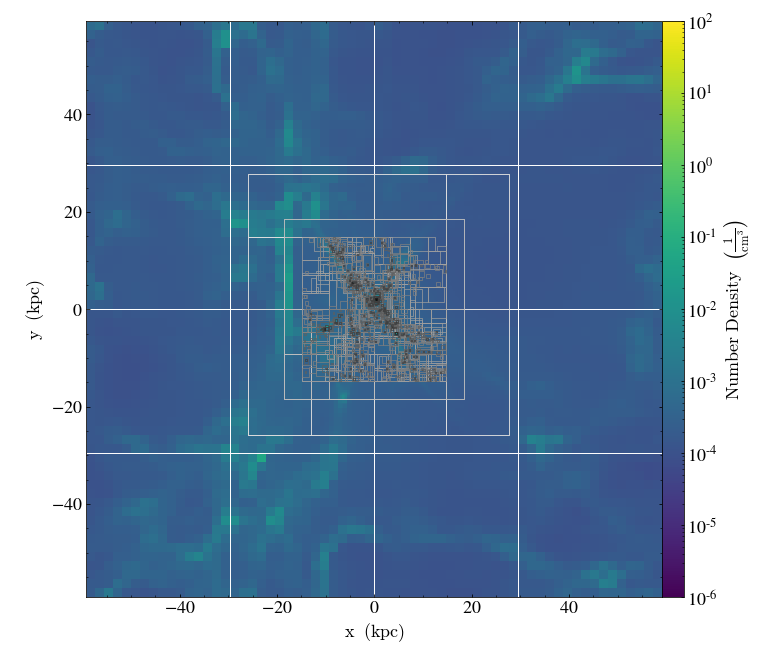

In [5]:

pp     = yt.ProjectionPlot(ds, 'z',
                          'number_density',
                           weight_field='number_density')
pp.set_cmap('number_density','viridis')
pp.set_zlim('number_density',1.0E-6,1.0E2)
pp.show()
pp.annotate_grids()

In [6]:
all_pp      = {}
particle_positions = {}

zoom_levels = [2,4,8,16,32,64, 128, 256, 512]
data   = ds.all_data()
center = data.argmax('density')

for zoom in zoom_levels:
    
    le = center - 0.5 * ds.domain_width * (1.0/zoom)
    re = center + 0.5 * ds.domain_width * (1.0/zoom)
    width = re - le
    region = ds.region(center,le,re)
    
    pp     = yt.ProjectionPlot(ds, 'z',
                              'number_density',
                               center = center,
                               weight_field='number_density',
                               data_source = region,
                               width=width)
    
    particle_positions[zoom] = {}
    select = region[('stars','birth_mass')] > 8.0
    particle_positions[zoom]['x'] = ((region[('stars','particle_position_x')][select].to('code_length')) - le[0].to('code_length'))/width[0].to('code_length')
    particle_positions[zoom]['y'] = ((region[('stars','particle_position_y')][select].to('code_length')) - le[1].to('code_length'))/width[1].to('code_length')
    
    
    pp.set_cmap('number_density','viridis')
    pp.set_zlim('number_density',1.0E-6,1.0E2)
    all_pp[zoom] = pp.frb['number_density']

/home/aemerick/code/yt/yt/data_objects/construction_data_containers.py:379: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(nvals, nwvals[:,None], nvals)
yt : [INFO     ] 2020-08-03 14:16:10,354 Projection completed
yt : [INFO     ] 2020-08-03 14:16:10,355 xlim = 92338390562021738283008.000000 274898085381397089878016.000000
yt : [INFO     ] 2020-08-03 14:16:10,355 ylim = 97330257217239029645312.000000 279889952036614381240320.000000
yt : [INFO     ] 2020-08-03 14:16:10,356 xlim = 0.252899 0.752899
yt : [INFO     ] 2020-08-03 14:16:10,356 ylim = 0.266571 0.766571
yt : [INFO     ] 2020-08-03 14:16:10,357 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
yt : [INFO     ] 2020-08-03 14:16:27,968 Making a fixed resolution buffer of (number_density) 800 by 800
yt : [INFO     ] 2020-08-03 14:16:33,096 Projection completed
yt : [INFO     ] 2020-08-03 14:16:33,097 xlim = 137978314266865559404544.000000 229258161676553268756480.000000
yt : [INFO   

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


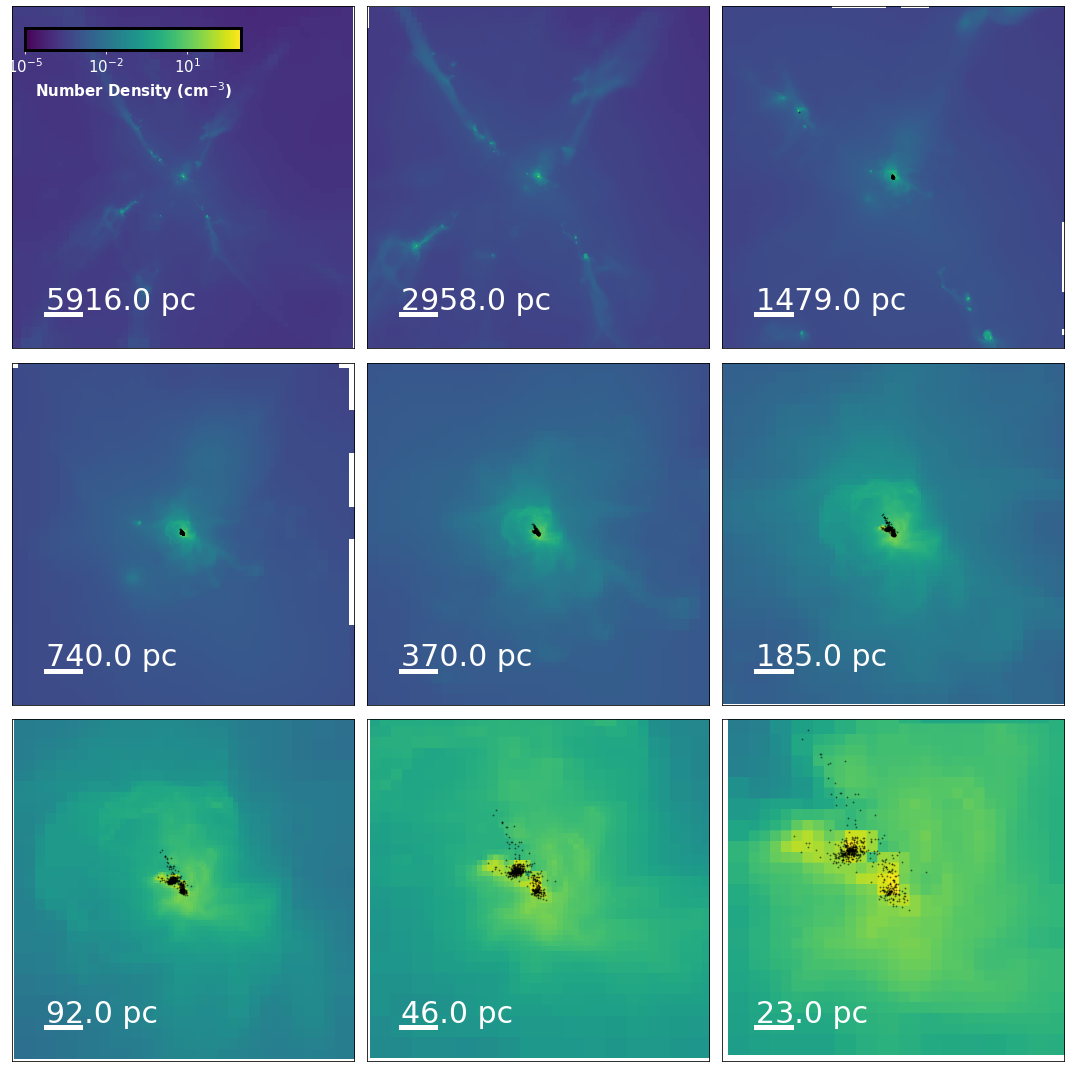

In [12]:
from matplotlib.colors import LogNorm

fs = 5
nrow,ncol=3,3


def set_colorbar_properties(figure, image, axes_coords, color = 'white'):
    """
    Set up colorbar properties given desired coordinates for a colorbar
    intended to be inside a plot and aligned horizontally. Sets 
    edge color, line width, and tick params to what will look good in
    this figure.
    """
    cb_ax = figure.add_axes(axes_coords)
    cbar = figure.colorbar(image, cax=cb_ax,orientation='horizontal')        
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(3)
    cbar.ax.tick_params(axis='both', colors=color,labelsize=15) #,weight='bold')    
        
    return cbar

#
# set up figure
#
fig, all_ax=plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(fs*ncol, fs*nrow)
fig.subplots_adjust(wspace = 0, hspace =0)
    

axi, axj = 0,0
# loop over all zooms
for zoom in all_pp:
    
    axindex = (axi,axj)
    ax = all_ax[axindex]
    
    #
    # Plot the image
    #
    im = ax.imshow(all_pp[zoom],  cmap = 'viridis', norm = LogNorm(), origin = 'lower',
                                  vmin = 1.0E-5, vmax = 1000.0,                                
                                  extent=[0,1,0,1])
    
    if zoom >= 8:
    #
    # for the higher zooms, start showing the star particles
    #
        ax.scatter(particle_positions[zoom]['x'],particle_positions[zoom]['y'], 
                   marker = '*', s = 1, color = 'black', alpha=0.5)
        
    
    #
    # For the first panel, show the colorbar on a new axis 
    # inside the figure
    #
    if axi == 0 and axj == 0:
        left = 0.025    
        fsize = 15
        lower, upper = 0.85, 0.95
        cbar = set_colorbar_properties(fig, im, [left, upper, 0.2, 0.02])
        cbar.set_label(r"Number Density (cm$^{-3}$)", size = fsize,color='white',weight='bold')

    #
    # Annotate a physical scale to each figure
    #
    x = [0.1,0.2]     
    ax.plot(x,[0.1,0.1], lw = 5, color = 'white')
    length = np.round(ds.domain_width[0].to('pc') / zoom * (x[1]-x[0]))
    ax.annotate("%.1f pc"%(length),(x[0],0.115),(x[0],0.115), xycoords='axes fraction', color = 'white', size = 30)
  

    #
    # Remove x and y ticks
    #
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    # iterate
    axj=axj+1
    if axj>=ncol:
        axj=0
        axi=axi+1
        
plt.tight_layout()



yt : [INFO     ] 2020-08-03 14:20:35,372 Projection completed
yt : [INFO     ] 2020-08-03 14:20:35,372 xlim = 1058543152334028931072.000000 366177932791084799229952.000000
yt : [INFO     ] 2020-08-03 14:20:35,373 ylim = 6050409807551320293376.000000 371169799446302090592256.000000
yt : [INFO     ] 2020-08-03 14:20:35,374 xlim = 0.002899 1.002899
yt : [INFO     ] 2020-08-03 14:20:35,374 ylim = 0.016571 1.016571
yt : [INFO     ] 2020-08-03 14:20:35,375 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
yt : [INFO     ] 2020-08-03 14:20:35,489 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



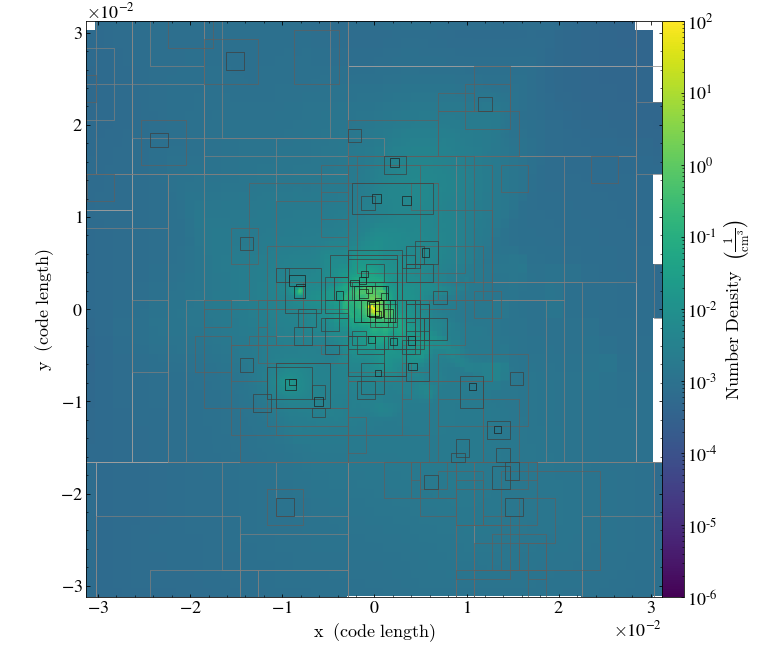

In [13]:
l = 1.0 / 32.0
center_code = np.array([c.to('code_length') for c in center]) 
le, re = center_code- l, center_code + l
reg = ds.region(center, le, re)
pp = yt.ProjectionPlot(ds,'z','number_density',center = center, weight_field='number_density',data_source=reg)
pp.set_width(2.0*l)
pp.set_cmap('number_density','viridis')
pp.set_zlim('number_density',1.0E-6,1.0E2)
pp.annotate_grids()

In [ ]:
#
#
# Load a pre-saved dataset containing star particle abundances and plot them
# 
#
#


In [75]:
def chunked_2dhist(chunks, xfield, yfield,
                   weight_field = None,
                   bins = 1024, range=[[-4,1],[-4,1]],                 
                   *args, **kwargs):
                   
    """
    Iterate through a chunked pandas dataset load to compute
    the 2D histogram for the whole dataset, summing together for each
    chunk.
    
    This function can be used generically for any fields in a 
    dataframe, but the default behavior is tooled specifically 
    to make plotting stellar abundances from a dataset of abundances,
    if those abundances are stored as 'X_over_H' where 'X' is a name
    of a metal / element in lowercase (e.g. 'fe_over_H'). In this case,
    this automatically computes related ratios (e.g. 'mg_over_fe') from the
    '_over_H' data.
    
    Additional args / kwargs are passed to `np.histogram2d`
    
    Parameters:
    chunks      : iterator over data frames. Can be the pandas
                  result from doing `pd.read_csv` with non-zero chunk-size,
                  or just a list of data frames.
                  
    xfield      : string. Name of field on x-axis
    
    yfield      : string. Name of field on y-axis
    
    weight_field: optional. String name of field to weight by. Default None,
                  so computes count of points in each bin
                  
    bins        : int, optional
                  Number of bins in each dimension. Fixed to be square. Default : 1024

    range:        array_like, shape(2,2), optional
                  The leftmost and rightmost edges of the bins along each dimension 
                  All values outside of this range will be considered outliers and will not
                  be included.
                  
    Returns:
    ----------
    
    Same output as np.histogram2d
    
    H       :    ndarray, shape(nx, ny)
                 The bi-dimensional histogram of samples x and y. Values in x are 
                 histogrammed along the first dimension and values in y are histogrammed
                 along the second dimension.

    xedges  :    ndarray, shape(nx+1,)
                 The bin edges along the first dimension.

    yedges:     ndarray, shape(ny+1,)
                The bin edges along the second dimension.    
    """
    result = np.zeros((bins,bins))
    
    for df in chunks:
        
        if weight_field is None:
            weights = None
            normed  = None
        else:
            weights = df[weight_field]
            normed  = False
            
            
        if ('_over_H' in xfield) or (not '_over_' in xfield):
            xvals = df[xfield]
        else:
            e1,e2 = xfield.split('_over_')
            xvals = df[e1 + '_over_H'] - df[e2 + '_over_H']
            
        if ('_over_H' in yfield) or (not '_over_' in yfield):
            xvals = df[yfield]
        else:
            e1,e2 = yfield.split('_over_')
            yvals = df[e1 + '_over_H'] - df[e2 + '_over_H']            
        
        H, xedges, yedges = np.histogram2d(xvals, yvals, *args, 
                                           weights=weights, 
                                           bins = bins, 
                                           range=range,
                                           normed = normed,
                                           **kwargs)
        
        result = result + H
        
    return result, xedges, yedges

In [97]:
import pandas as pd
from more_itertools import seekable

df_chunks = seekable(pd.read_csv('./input/m12q_res7100_stars.dat', header=0, sep = " ",
                        chunksize=10000))

In [98]:



H, xedges, yedges = chunked_2dhist(df_chunks, 'fe_over_H', 'o_over_fe',
                                   weight_field = 'mass')


(-1, 1)

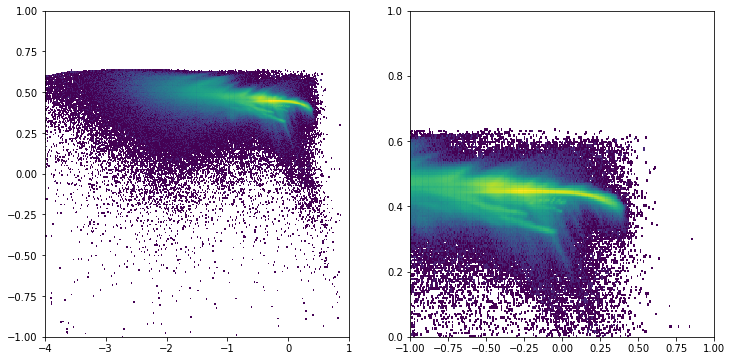

In [131]:

fig, ax = plt.subplots(1,2) #sharey=True)
fig.set_size_inches(12,6)
#fig.subplots_adjust(wspace=0)

X, Y = np.meshgrid(xedges, yedges)
ax[0].pcolormesh(X, Y, H.T, norm = LogNorm())
ax[0].set_ylim(-1,1)
ax[0].set_xlim(-4,1)

ax[1].pcolormesh(X, Y, H.T, norm = LogNorm())
ax[1].set_ylim(0,1)
ax[1].set_xlim(-1,1)

In [86]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [133]:
df_chunks.seek(0)
fe = np.concatenate([df['fe_over_H'] for df in df_chunks]).ravel()
df_chunks.seek(0)

o  = np.concatenate([(df['o_over_H']-df['fe_over_H']) for df in df_chunks]).ravel()
X = np.array([fe,o])
X = X.T

In [ ]:
k_means = KMeans(init='k-means++', n_clusters=12, n_init=10)
k_means.fit(X)


In [ ]:
l = k_means.labels_

In [ ]:
select = np.zeros(np.shape(X)[0], dtype=int)
select[:10000] = 1
np.random.shuffle(select)
select = select.astype(bool)
plt.scatter(X[:,0][select],X[:,1][select],c=l[select])